## 0. Model and problem to solve

Given an envelope $f(t)$ and phase $\phi$, the Hamiltonian is a transmon model with Hamiltonian:
$$H(t) = 2 \pi \nu N + \pi \alpha N (N-1) + 2 \pi r Re[f(t)e^{i 2 \pi \nu t + \phi}](a + a^\dagger)$$
where
- $\nu$ is the qubit fruquency,
- $\alpha$ is the anharmonicity,
- $r$ is the drive strength, and
- $f(t)$ is the drive envelope, and $\phi$ is the drive phase.

For the objective terms, we aim to optimize a $\pi/2$-pulse, and will run the optimization with an objective function which is a linear combination of the following terms. Denote $A$ as the isometry from the computational states to the full physical space, and $P = AA^\dagger$. Furthermore, denote $\|\cdot\|$ as the Hilbert-Schmidt norm, and let $\Phi$ denote the linear map $\Phi(A) = A - Tr(A)I/d$, where $I$ is the identity and $d$ is the smaller of the two dimensions of a rectangular matrix.
- Infidelity of the unitary with input/output restricted to the computational subspace $|Tr(XA^\dagger U(T)A)|^2 / 4$.
- First order robustness to frequency variations off-resonance:  $\|\Phi(\frac{dU(T)}{d\nu} A)\|$. Here we're abusing notation as there is no $\nu$ in the Hamiltonian, but we mean this with respect to an additional term $2 \pi \nu N$.
- First order robustness to drive amplitude variations $\|\Phi(\frac{dU(t)}{dr}A)\|$.
- An "energy penalty" averaged over the whole pulse length $Tr[A^\dagger(\int_0^T dt U^\dagger(t)NU(t))A]$.
- A leakage penalty at the end of the pulse $\|U(T)A\|$ (norm of part of unitary mapping computational subspace to leakage states). Note that the infidelity term implicitly includes this within itself (i.e. the infidelity cannot be $0$ without this term being $0$), but this allows us to weight it more strongly to penalize final leakage more than coherent errors.

In [1]:
import sys
sys.path.insert(1, 'src/')

## 1. Defining operators and constants

First, we'll define operators and constants.

In [2]:
import jax
jax.config.update("jax_enable_x64", True)

# tell JAX we are using CPU
jax.config.update('jax_platform_name', 'cpu')

import numpy as np

# dimension
dim = 4

# some fixed model parameters
freq = 4.725
anharm = -0.35
r = 0.08

# operators
a = np.diag(np.sqrt(np.arange(1, dim)), 1) + 0j
adag = np.diag(np.sqrt(np.arange(1, dim)), -1) + 0j
N = np.diag(np.arange(dim)) + 0j

static_hamiltonian = 2 * np.pi * freq * N + np.pi * anharm * N * (N - np.eye(dim)) + 0j
drive_hamiltonian_X = 2 * np.pi * r * (a + adag) + 0j

freq_operator = N + 0j

## 2. Define the signal parameterization

A way of parameterizing an envelope we currently use regularly is encoded in the function `chebyshev_parameterization`.

The doc string for the function goes into the details of how it constructs a signal. Note that the number of chebyshev polynomials used in the parameterization is determined by the length of the parameter vector.

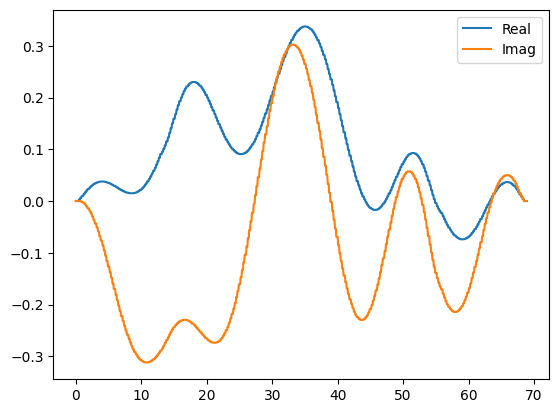

In [3]:
from parameterization import chebyshev_parameterization

dt = 1 / 4.5 # sample width
n_steps = 250 # base number of time steps
n_zeros = 30 # amount of padding used in convolution for smoothing
cutoff_freq = 0.3
num_params = 10

T = (n_steps + 2 * n_zeros) * dt

example_sig = chebyshev_parameterization(
    I_params=np.random.rand(num_params),
    Q_params=np.random.rand(num_params),
    dt=dt,
    cutoff_freq=cutoff_freq,
    n_steps=n_steps,
    n_zeros=n_zeros
)
example_sig.draw(0, dt * len(example_sig.samples), 1000, function="envelope")

For the parameterization to be consumable by the helper functions, we need to define a dictionary of the form: `{signal_name: parameterization}`, where `parameterization` is a function on the input dictionary of parameters, and returns a Qiskit Dynamics signal.

In this case, since we did the RWA by hand, we need to parameterize two separate signals for the I and Q components.

In [4]:
# use the same function for I and Q components
signal_func = lambda x, y, phase: chebyshev_parameterization(
    I_params=x,
    Q_params=y,
    dt=dt,
    n_steps=n_steps,
    n_zeros=n_zeros,
    phase=phase,
    cutoff_freq=cutoff_freq,
    carrier_freq=freq
)

pi2 = np.pi/2

signal_parameterizations = {
    "sigX": lambda opt_parameters: signal_func(
        x=opt_parameters["I_params"],
        y=opt_parameters["Q_params"],
        phase=opt_parameters["phase"]
    )
}

## 3. Define the model and perturbations

Here we define the model as a Hamiltonian in a dictionary format. The format is: `{signal_name: operator}`, with the signal name `drift` reserved for the constant part of the Hamiltonian.

In [5]:
model = {
    "drift": static_hamiltonian,
    "sigX": drive_hamiltonian_X
}

The perturbations are defined similarly in a dictionary format. 

Aside: This is kind of annoying, but the keys for the perturbations need to be collections of labels (more generally to allow for higher level perturbations), but they also need to be hashable, so here we use `frozenset`.

In [6]:
perturbations = {
    frozenset(["freq"]): {"drift": freq_operator},
    frozenset(["amp"]): {
        "sigX": drive_hamiltonian_X / (2 * np.pi * r)
    },
    frozenset(["energy"]): {"drift": N} # setting energy penalty to higher levels
}

Finally, we can set a rotating frame to perform the computation in.

In [7]:
# remove the diag if model is not diagonal!
rotating_frame = np.diag(model["drift"])

## 4. Define objective functions and weights

Lastly, we define the objective functions we want to compute. This will be a minimization problem.

In [8]:
from objectives import fidelity, traceless_hs_norm
import jax.numpy as jnp
from scipy.linalg import expm

X = np.array([[0., 1.], [1., 0.]])

#U_target = X
U_target = expm(-1j * (np.pi/4) * X)

def robustness(results, name):
    mat = results.perturbation_data.get_item([name])[-1]
    return traceless_hs_norm(mat[:, 0:2])

P = jnp.diag(np.append(np.ones(2), np.zeros(dim-2)))
ave_energy_normalization = jnp.real(jnp.trace(N)) * T

def ave_energy(results):
    mat = 1j * results.perturbation_data.get_item(["energy"])[-1]
    return jnp.real(jnp.trace(P @ mat @ P)) / ave_energy_normalization
                    
def final_leakage(results):
    # mapping of input computational subspace to output leakage
    U = results.y[-1][2:, 0:2]
    return jnp.linalg.norm(U)

objective_functions = {
    "infidelity": lambda results: 1 - fidelity(results.y[-1], U_target),
    "freq_robustness": lambda results: robustness(results, "freq") / T,
    "amp_robustness": lambda results: robustness(results, "amp") / T,
    "ave_energy": ave_energy,
    "final_leakage": final_leakage
}
                    
objective_weights = {
    "infidelity": 1.,
    "freq_robustness": 5.,
    "amp_robustness": 5.,
    "ave_energy": 0.1,
    "final_leakage": 1.
}

In [9]:
U_target

array([[0.70710678+0.j        , 0.        -0.70710678j],
       [0.        -0.70710678j, 0.70710678+0.j        ]])

## 5. Compute objective function

In [10]:
from optimization_workflow_helpers import perturbative_objective_function

objective = lambda params: perturbative_objective_function(
    opt_parameters=params,
    signal_parameterizations=signal_parameterizations,
    model=model,
    rotating_frame=rotating_frame,
    perturbations=perturbations,
    t_span=[0, T],
    objective_functions=objective_functions,
    objective_weights=objective_weights,
    expansion_method="dyson",
    expansion_order=1,
    integration_method="jax_odeint",
    atol=1e-10,
    rtol=1e-10
)

## 6. Running an optimization

Here we'll use the package `jaxopt` to run the optimization.

In [11]:
init_params = {
    "I_params": (np.random.rand(num_params) - 0.5) * 0.01,
    "Q_params": (np.random.rand(num_params) - 0.5) * 0.01,
    "phase": np.random.rand() * 2 * np.pi
}

objective(init_params)

Array(4.04307956, dtype=float64)

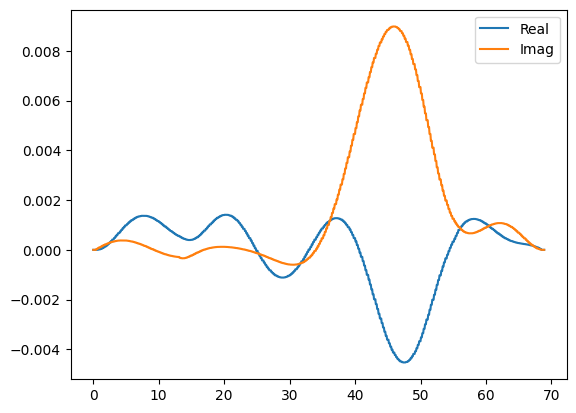

In [12]:
init_sig = signal_parameterizations["sigX"](init_params)
init_sig.draw(0, T, 1000, function="envelope")

Run the optimization.

In [13]:
from jaxopt import BFGS

# small for verifying notebook runs
# to generate the pulse we used we ran this notebook many times with maxiter=2000
maxiter = 1

optimizer = BFGS(fun=objective, maxiter=maxiter)
opt_res = optimizer.run(init_params)

INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.10449491049212412 Stepsize:1.0  Decrease Error:0.10449491049212412  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): 0.046611589709662726 Stepsize:0.4993327198209444  Decrease Error:0.046611589709662726  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 3 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.21076511552813973  Decrease Error:0.0  Curvature Error:0.0 


## 7. Looking at solution

The optimized parameters.

In [14]:
opt_res.params

{'I_params': Array([-1.68789945e+00, -5.36779679e-03,  5.68940302e-01,  7.96879010e-03,
         1.12187498e-01, -1.39312597e-03,  4.61280651e-02, -4.95812842e-07,
         2.82093685e-02,  4.72821156e-03], dtype=float64),
 'Q_params': Array([ 0.5046994 ,  0.01369024, -0.18335358, -0.01801284, -0.02371282,
         0.00584481, -0.00752277, -0.00256176, -0.00954879, -0.00207635],      dtype=float64),
 'phase': Array(3.60860862, dtype=float64)}

The value achieved.

In [15]:
opt_res.state.value

Array(3.02014375, dtype=float64)

The signal envelope.

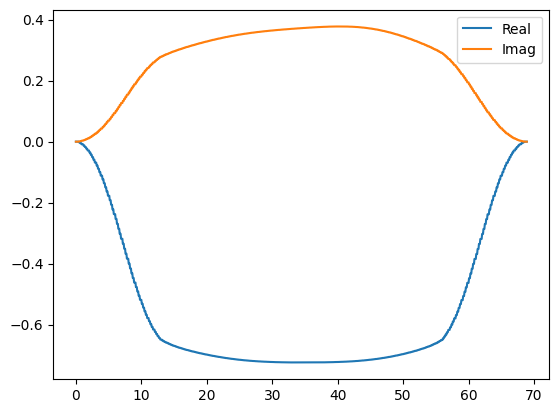

In [16]:
sigX = signal_parameterizations["sigX"](opt_res.params)
sigX.draw(0, T, 1000, function="envelope")

We can view the individual objective functions (this is a bit awkward, and there should be a more convenient interface for this, but for now it's fine).

In [17]:
from optimization_workflow_helpers import optimization_perturbation_sim

ode_result = optimization_perturbation_sim(
    opt_parameters=opt_res.params,
    signal_parameterizations=signal_parameterizations,
    model=model,
    rotating_frame=rotating_frame,
    perturbations=perturbations,
    t_span=[0, T],
    expansion_method="dyson",
    expansion_order=1,
    integration_method="jax_odeint",
    atol=1e-10,
    rtol=1e-10
)

In [18]:
opt_objectives = {k: func(ode_result) for k, func in objective_functions.items()}

In [19]:
opt_objectives

{'infidelity': Array(0.11583565, dtype=float64),
 'freq_robustness': Array(0.14971389, dtype=float64),
 'amp_robustness': Array(0.42760352, dtype=float64),
 'ave_energy': Array(0.16862699, dtype=float64),
 'final_leakage': Array(0.0008583, dtype=float64)}